## Загружаем библиотеки

In [1]:
import sys
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import TicTacToe as ttt

import copy
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as T

from tqdm import tqdm
from torch.autograd import Variable
from torch.utils.data import Dataset

import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
sns.set_theme(style="darkgrid")

## Вспомогательные функции и переменные

In [2]:
def replace_state(state):
    """
    Вспомогательная функция для
    инвертирования текущенго игрового состояния
    для второго игрока для использования одних функция 
    для обучения и оценки качества
    """
    res = ""
    for s in state:
        res += str(2 - int(s))
    return res

## Часть первая: крестики-нолики при помощи Q-обучения
В коде, прилагающемся к последней лекции про обучение с подкреплением, реализован Environment для крестиков-ноликов, в котором можно при инициализации указывать разные размеры доски и условия победы, а также функции для рисования, в том числе с указанием оценки различных действий. С этим окружением все задания и связаны.

Протестируем окружение рандомной тестовой игрой <br />
Попробуем простые движения для понимания работы окружения <br />
и возвращаемые значения методов и переменных окружения

In [3]:
# создаем окружения
env_33 = ttt.TicTacToe(n_rows=3, n_cols=3, n_win=3)
env_33.printBoard(), env_33.isTerminal(), env_33.getEmptySpaces(), env_33.gameOver, env_33.getHash()

-------------
|   |   |   | 
-------------
|   |   |   | 
-------------
|   |   |   | 
-------------


(None,
 None,
 array([[0, 0],
        [0, 1],
        [0, 2],
        [1, 0],
        [1, 1],
        [1, 2],
        [2, 0],
        [2, 1],
        [2, 2]]),
 False,
 '111111111')

In [4]:
action = [0, 0]
env_33.step(action);
env_33.printBoard(), env_33.isTerminal(), env_33.getEmptySpaces(), env_33.gameOver, env_33.getHash()

-------------
| x |   |   | 
-------------
|   |   |   | 
-------------
|   |   |   | 
-------------


(None,
 None,
 array([[0, 1],
        [0, 2],
        [1, 0],
        [1, 1],
        [1, 2],
        [2, 0],
        [2, 1],
        [2, 2]]),
 False,
 '211111111')

In [5]:
action = [0, 0]
env_33.step(action);
env_33.printBoard(), env_33.isTerminal(), env_33.getEmptySpaces(), env_33.gameOver, env_33.getHash()

-------------
| x |   |   | 
-------------
|   |   |   | 
-------------
|   |   |   | 
-------------


(None,
 None,
 array([[0, 1],
        [0, 2],
        [1, 0],
        [1, 1],
        [1, 2],
        [2, 0],
        [2, 1],
        [2, 2]]),
 False,
 '211111111')

In [6]:
action = [0, 1]
env_33.step(action);
env_33.printBoard(), env_33.isTerminal(), env_33.getEmptySpaces(), env_33.gameOver, env_33.getHash()

-------------
| x | o |   | 
-------------
|   |   |   | 
-------------
|   |   |   | 
-------------


(None,
 None,
 array([[0, 2],
        [1, 0],
        [1, 1],
        [1, 2],
        [2, 0],
        [2, 1],
        [2, 2]]),
 False,
 '201111111')

In [7]:
action = [1, 1]
env_33.step(action);
env_33.printBoard(), env_33.isTerminal(), env_33.getEmptySpaces(), env_33.gameOver, env_33.getHash()

-------------
| x | o |   | 
-------------
|   | x |   | 
-------------
|   |   |   | 
-------------


(None,
 None,
 array([[0, 2],
        [1, 0],
        [1, 2],
        [2, 0],
        [2, 1],
        [2, 2]]),
 False,
 '201121111')

In [8]:
action = [2, 1]
env_33.step(action);
env_33.printBoard(), env_33.isTerminal(), env_33.getEmptySpaces(), env_33.gameOver, env_33.getHash()

-------------
| x | o |   | 
-------------
|   | x |   | 
-------------
|   | o |   | 
-------------


(None,
 None,
 array([[0, 2],
        [1, 0],
        [1, 2],
        [2, 0],
        [2, 2]]),
 False,
 '201121101')

In [9]:
action = [2, 2]
env_33.step(action);
env_33.printBoard(), env_33.isTerminal(), env_33.getEmptySpaces(), env_33.gameOver, env_33.getHash()

-------------
| x | o |   | 
-------------
|   | x |   | 
-------------
|   | o | x | 
-------------


(None,
 None,
 array([[0, 2],
        [1, 0],
        [1, 2],
        [2, 0]]),
 False,
 '201121102')

In [10]:
action = [1, 2]
env_33.step(action);
env_33.printBoard(), env_33.isTerminal(), env_33.getEmptySpaces(), env_33.gameOver, env_33.getHash()

-------------
| x | o |   | 
-------------
|   | x | o | 
-------------
|   | o | x | 
-------------


(None,
 1,
 array([[0, 2],
        [1, 0],
        [2, 0]]),
 True,
 '201120102')

### 1. Реализуйте обычное (табличное) Q-обучение. Обучите стратегии крестиков и ноликов для доски 3х3.

In [11]:
def play_one_game(env, p1_strategy, p2_strategy, verbose=False):
    """
    Реализация одной игры
    env - окружение
    p1_strategy - стратегия первого игрока (крестики)
    p2_strategy - стратегия второго игрока (нолики)
    verbose - отражаем доску после каждого хода
    """
    env.reset()
    done = False
    
    while not done:
        s, actions = env.getHash(), env.getEmptySpaces()
        cnt_acts = len(actions)
        
        if env.curTurn == 1:
            if p1_strategy.index_best_action:
                a = actions[p1_strategy.get_best_action(s, cnt_acts)]
            else:
                a = p1_strategy.get_best_action(s)
        else:
            if p2_strategy.index_best_action:
                a = actions[p2_strategy.get_best_action(replace_state(s), cnt_acts)]
            else:
                a = p2_strategy.get_best_action(replace_state(s))
                
        observation, reward, done, info = env.step(a)
        
        if verbose:
            env.printBoard()
    
    if verbose:
        if reward == 1:
            print("Победил игрок на крестиках")
        elif reward == -1:
            print("Победил игрок на ноликах")
        else:
            print("Победила Дружба, у нас ничья")
            
    return reward

In [12]:
class PlayerSimpleStrategy():
    """
    Простая стратегия, кидаем рандом
    на кол-во свободных клеток и делаем ход
    """
    def __init__(self):
        self.index_best_action = True

        
    def get_best_action(self, state, cnt_acts=None):
        if cnt_acts is None:
            acts = [i for i in list(state) if i == '1']
            cnt_acts = len(acts)
        return random.randint(0, cnt_acts-1)

In [13]:
simple_strategy = PlayerSimpleStrategy()
play_one_game(env_33, simple_strategy, simple_strategy, True)

-------------
|   | x |   | 
-------------
|   |   |   | 
-------------
|   |   |   | 
-------------
-------------
|   | x |   | 
-------------
|   |   |   | 
-------------
|   |   | o | 
-------------
-------------
|   | x |   | 
-------------
|   |   | x | 
-------------
|   |   | o | 
-------------
-------------
|   | x |   | 
-------------
| o |   | x | 
-------------
|   |   | o | 
-------------
-------------
| x | x |   | 
-------------
| o |   | x | 
-------------
|   |   | o | 
-------------
-------------
| x | x |   | 
-------------
| o |   | x | 
-------------
|   | o | o | 
-------------
-------------
| x | x |   | 
-------------
| o |   | x | 
-------------
| x | o | o | 
-------------
-------------
| x | x |   | 
-------------
| o | o | x | 
-------------
| x | o | o | 
-------------
-------------
| x | x | x | 
-------------
| o | o | x | 
-------------
| x | o | o | 
-------------
Победил игрок на крестиках


1

In [14]:
def strategy_evaluation(env, p1_strategy, p2_strategy, 
                        num_games=1000, verbose=False):
    """
    Оценка предложенной стратегии
    для некоторого кол-ва игр num_games
    """
    player1_wins = 0
    player2_wins = 0
    draws = 0
    if verbose:
        for i in tqdm(range(num_games), file=sys.stdout):
            reward = play_one_game(env, p1_strategy, p2_strategy, False)

            if reward == 1:
                player1_wins += 1
            elif reward == -1:
                player2_wins += 1
            else:
                draws += 1
    else:
        for i in range(num_games):
            reward = play_one_game(env, p1_strategy, p2_strategy, False)

            if reward == 1:
                player1_wins += 1
            elif reward == -1:
                player2_wins += 1
            else:
                draws += 1
    if verbose:
        print(" Победа крестики - " + str(round(player1_wins / num_games, 4) * 100) + "%\n", \
              "Победа нолики - " +  str(round(player2_wins / num_games, 4) * 100) + "%\n", \
              "Ничья - " + str(round(draws / num_games, 4) * 100) + "%")
    return player1_wins / num_games, player2_wins / num_games

In [15]:
env_33 = ttt.TicTacToe(n_rows=3, n_cols=3, n_win=3)
simple_strategy = PlayerSimpleStrategy()
strategy_evaluation(env_33, simple_strategy, simple_strategy, num_games=10000, verbose=True);

100%|██████████| 10000/10000 [00:03<00:00, 3021.68it/s]
 Победа крестики - 58.209999999999994%
 Победа нолики - 29.330000000000002%
 Ничья - 12.46%


In [16]:
class QStrategy:
    def __init__(self, alpha, gamma):
        self.index_best_action = True
        self.alpha = alpha
        self.gamma = gamma   
        self.Qtable = {}
        
        
    def get_value(self, state, cnt_acts=None):
        if state not in self.Qtable:
            if cnt_acts is None:
                acts = [i for i in list(state) if i == '1']
                cnt_acts = len(acts)
            self.Qtable[state] = np.zeros(cnt_acts)
        return self.Qtable[state]

    
    def update(self, state, cnt_acts, reward, next_state):
        Q = self.get_value(state)[cnt_acts]
        if next_state is None:
            self.Qtable[state][cnt_acts] = Q + self.alpha * (reward - Q)
        else:
            V = np.max(self.get_value(next_state))
            self.Qtable[state][cnt_acts] = Q + self.alpha * (reward + self.gamma * V - Q)
      
    
    def get_best_action(self, state, cnt_acts=None):
        return np.argmax(self.get_value(state, cnt_acts))
        
    
    def get_action(self, state, epsilon, cnt_acts=None):
        """eps-greedy action"""
        if random.random() > epsilon:
            return self.get_best_action(state, cnt_acts)
        else:
            if cnt_acts is None:
                acts = [i for i in list(state) if i == '1']
                cnt_acts = len(acts)
            return random.randint(0, cnt_acts-1)

In [18]:
def QLearning(env, q_strategy, random_strategy, eps, max_iter):
    """ Реализация Q-обучения"""
    
    player_1, player_2 = [], []
    for i in tqdm(range(max_iter), file=sys.stdout):
        
        eps_upd = eps * (max_iter - i) / max_iter
        
        if (i % 10000) == 0:
            p1, p2 = strategy_evaluation(env, q_strategy, random_strategy)
            player_1.append((i + 1, p1))
            
            p1, p2 = strategy_evaluation(env, random_strategy, q_strategy)
            player_2.append((i + 1, p2))
            
        done = False
        env.reset()

        s_pred, act_pred = env.getHash(), env.getEmptySpaces()
        cnt_act_pred = q_strategy.get_action(s_pred, eps_upd, len(act_pred))
        obs, reward, done, info = env.step(act_pred[cnt_act_pred])
        
        s_cur, act_cur = obs[0], obs[1]
        curTurn = env.curTurn
        s_cur = replace_state(s_cur)
        
        while not done:
            cnt_act_cur = q_strategy.get_action(s_cur, eps_upd, len(act_cur))
            obs, reward, done, info = env.step(act_cur[cnt_act_cur])
            
            if done: 
                q_strategy.update(s_pred, cnt_act_pred, -reward * curTurn, None)
                q_strategy.update(s_cur, cnt_act_cur, reward * curTurn, None)
                break

            s_next = obs[0]
            curTurn = env.curTurn
            if curTurn == -1:
                s_next = replace_state(s_next)
                
            q_strategy.update(s_pred, cnt_act_pred, reward, s_next)
            s_pred, act_pred = s_cur, act_cur
            s_cur, act_cur = s_next, obs[1]
            cnt_act_pred = cnt_act_cur
            
    return player_1, player_2

In [19]:
%%time
eps = 0.3
alpha = 0.1
gamma = 0.9
max_iter = 500000

env_33 = ttt.TicTacToe(n_rows=3, n_cols=3, n_win=3)
q_strategy = QStrategy(alpha, gamma)

player_1, player_2 = QLearning(env_33, q_strategy, simple_strategy, eps, max_iter)

100%|██████████| 500000/500000 [05:31<00:00, 1509.38it/s]
CPU times: user 5min 14s, sys: 19.2 s, total: 5min 33s
Wall time: 5min 31s


Играем q-стратегией за крестики

In [20]:
strategy_evaluation(env_33, q_strategy, simple_strategy, 100000, True)

100%|██████████| 100000/100000 [00:28<00:00, 3476.52it/s]
 Победа крестики - 98.0%
 Победа нолики - 0.0%
 Ничья - 2.0%


(0.98, 0.0)

Играем q-стратегией за нолики

In [21]:
strategy_evaluation(env_33, simple_strategy, q_strategy, 100000, True)

100%|██████████| 100000/100000 [00:34<00:00, 2926.45it/s]
 Победа крестики - 0.61%
 Победа нолики - 81.8%
 Ничья - 17.59%


(0.00611, 0.81798)

Натравим q-стратегию крестиков на q-стратегию ноликов. Надеемся, что они достойны друг-друга

In [22]:
strategy_evaluation(env_33, q_strategy, q_strategy, 100000, True)

100%|██████████| 100000/100000 [00:48<00:00, 2050.99it/s]
 Победа крестики - 0.0%
 Победа нолики - 0.0%
 Ничья - 100.0%


(0.0, 0.0)

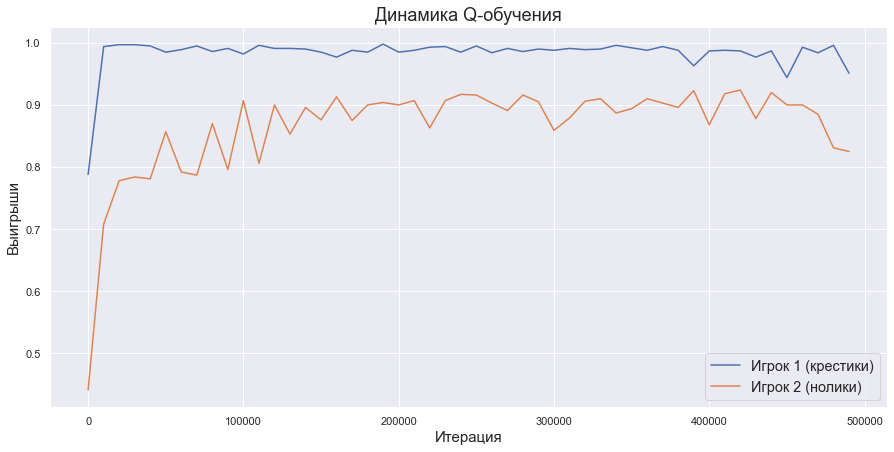

In [23]:
fig, ax = plt.subplots(1, figsize=(15, 7))

x, y = [], []
for i in player_1:
    x.append(i[0])
    y.append(i[1])
    
sns.lineplot(x, y, label="Игрок 1 (крестики)")

x, y = [], []
for i in player_2:
    x.append(i[0])
    y.append(i[1])
    
sns.lineplot(x, y, label="Игрок 2 (нолики)")

ax.set_ylabel('Выигрыши', fontsize=15)
ax.set_xlabel('Итерация', fontsize=15)
plt.legend(loc="best", fontsize="large")
plt.title('Динамика Q-обучения', fontsize=18);

### 2. Попробуйте обучить стратегии крестиков и ноликов для доски 4х4

In [24]:
%%time
eps = 0.2
alpha = 0.05
gamma = 0.95
max_iter = 1000000

q_strategy = QStrategy(alpha, gamma)
simple_strategy = PlayerSimpleStrategy()
env_44 = ttt.TicTacToe(n_rows=4, n_cols=4, n_win=4)

player_1, player_2 = QLearning(env_44, q_strategy, simple_strategy, eps, max_iter)

100%|██████████| 1000000/1000000 [22:19<00:00, 746.67it/s] 
CPU times: user 21min 59s, sys: 1min 1s, total: 23min 1s
Wall time: 22min 19s


Играем q-стратегией за крестики

In [25]:
strategy_evaluation(env_44, q_strategy, simple_strategy, 100000, True)

100%|██████████| 100000/100000 [01:15<00:00, 1324.92it/s]
 Победа крестики - 65.36999999999999%
 Победа нолики - 16.18%
 Ничья - 18.45%


(0.65373, 0.16181)

Играем q-стратегией за нолики

In [26]:
strategy_evaluation(env_44, simple_strategy, q_strategy, 100000, True)

100%|██████████| 100000/100000 [01:24<00:00, 1184.68it/s]
 Победа крестики - 23.84%
 Победа нолики - 47.199999999999996%
 Ничья - 28.96%


(0.23841, 0.47197)

Натравим q-стратегию крестиков на q-стратегию ноликов. Надеемся, что они достойны друг-друга

In [27]:
strategy_evaluation(env_44, q_strategy, q_strategy, 100000, True)

100%|██████████| 100000/100000 [01:56<00:00, 861.08it/s]
 Победа крестики - 0.0%
 Победа нолики - 0.0%
 Ничья - 100.0%


(0.0, 0.0)

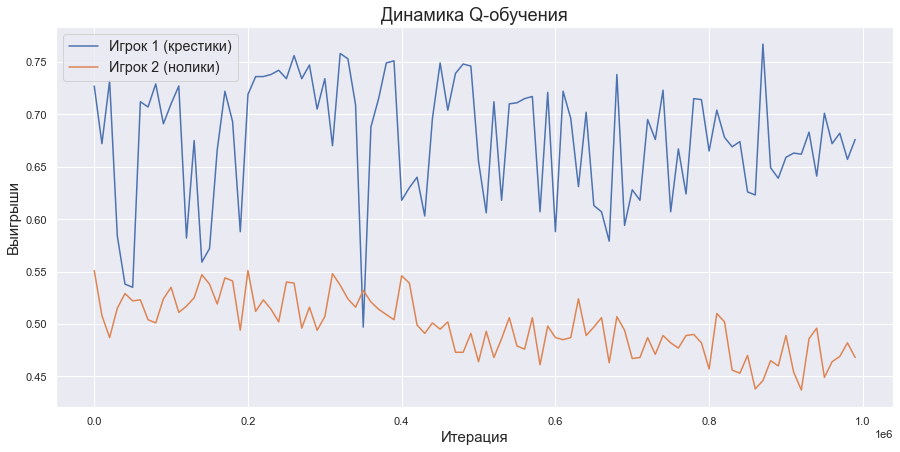

In [28]:
fig, ax = plt.subplots(1, figsize=(15, 7))

x, y = [], []
for i in player_1:
    x.append(i[0])
    y.append(i[1])
    
sns.lineplot(x, y, label="Игрок 1 (крестики)")

x, y = [], []
for i in player_2:
    x.append(i[0])
    y.append(i[1])
    
sns.lineplot(x, y, label="Игрок 2 (нолики)")

ax.set_ylabel('Выигрыши', fontsize=15)
ax.set_xlabel('Итерация', fontsize=15)
plt.legend(loc="best", fontsize="large")
plt.title('Динамика Q-обучения', fontsize=18);

По результатам на доске 4x4 вроде q-learning обучился, можно убедиться на 100% ничьих при игре q-стратегии на крестиках и ноликах. С другой стороны, не прослеживается на графике тренд на улучшение результатов для каждого из игроков. Возможно, здесь уже надо в разы увеличивать итерации, да и параметры потюнить

### Часть вторая: добавим нейронных сетей
Реализуйте нейронную сеть для метода DQN на доске для крестиков-ноликов. Не буду ограничивать фантазию, но кажется, что свёртки 3х3 здесь должны неплохо работать (в том числе обобщаться на доски размера побольше).

3.	Реализуйте DQN с нейронной сетью, обучите стратегии крестиков и ноликов. Замечание: скорее всего, experience replay потребуется сразу же.

Не получилось реализовать DQN, лишний код был вычищен из тетрадки